**Define all constants used in the process training and testing the model.**

This should be the only field user has to modify

In [1]:
# Path to the inside of a folder containing all audio files
DATA_PATH = r"D:\AGH\ISZ\Deep learning\dl_data\ASVspoof2021_DF_eval\flac"

# Path to the CSV file containing names of the flac files in the folder indicated by DATA_PATH constant
# and information whether those files contain "fake" or "real" recording
FAKE_OR_REAL_PATH = r"fake_or_real.csv"

# How many audio files will be processed at once, before being fed to neural network
# Pro tip: do not go overboard with this, or your RAM will burn :)
# Must be divisible by 2!
PROCESS_BATCH_SIZE = int(1000)

# How many files will be proccessed for training in total
# Must be divisible by 2!
NUM_OF_FILES = int(10000)

# Sampling rate of audio file
SAMPLING_RATE = 16000

# How many seconds of recording will be processed
# If recording is shorter, remaining data will be filled with zeros
NUM_OF_SECONDS = 3

# Number of batches that will be used for tests
BATCHES_FOR_TESTS = 2

# Fow how many iterations will a single filename_batch be fed to neural network
EPOCHS = 100

# Size of a batch fed at once to neural network
# Can not be greater than half of PROCESS_BATCH_SIZE!
TRAIN_BATCH_SIZE = int(25)

# Name of file to which network will be saved
MODEL_NAME = "LSTM_NETWORK_5"

**Import all necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import os
import librosa
# import librosa.display
import IPython
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import joblib

random.seed(100)

**Check whether constant values provided by user were correct**

In [3]:
if not os.path.exists(DATA_PATH):
    raise ValueError("Path to folder containing FLAC files does not exist!")

try:
    fake_or_real_df = pd.read_csv(FAKE_OR_REAL_PATH)
except:
    raise ValueError("Couldn't open CSV file with information about whether data is fake or real!")

fake_data = fake_or_real_df[fake_or_real_df.iloc[:, 1] == "fake"]
real_data = fake_or_real_df[fake_or_real_df.iloc[:, 1] == "real"]
print("Total number of fake files = {}".format(len(fake_data)))
print("Total number of real files = {}".format(len(real_data)))

if PROCESS_BATCH_SIZE % 2 != 0:
    raise ValueError("FILE_BATCH_SIZE must be divisible by 2!")

if NUM_OF_FILES % 2 != 0:
    raise ValueError("NUM_OF_FILES must be divisible by 2!")

if (NUM_OF_FILES / 2) >= len(real_data):
    raise ValueError("Folder does not contain enough samples of real data! Pleace reduce the NUM_OF_FILES constant!")

if (NUM_OF_FILES / 2) >= len(fake_data):
    raise ValueError("Folder does not contain enough samples of fake data! Pleace reduce the NUM_OF_FILES constant!")

if TRAIN_BATCH_SIZE > PROCESS_BATCH_SIZE / 2:
    raise ValueError("TRAIN_BATCH_SIZE can not be greater than half of PROCESS_BATCH_SIZE!")

Total number of fake files = 589212
Total number of real files = 22617


**Select files with fake and real data**

In [ ]:
# Function that will be used to split dataframe
def splitDataframe(df, batch_size=10000): 
    chunks = list()
    num_chunks = int(np.ceil(len(df) / batch_size))
    for i in range(num_chunks):
        chunks.append(df[i*batch_size:(i+1)*batch_size])
    return chunks


# Chose indices and split them into batches
real_idx_batches = splitDataframe(random.sample(list(real_data.index), NUM_OF_FILES // 2), PROCESS_BATCH_SIZE // 2)
fake_idx_batches = splitDataframe(random.sample(list(fake_data.index), NUM_OF_FILES // 2), PROCESS_BATCH_SIZE // 2)

# Get each batch of indices load filenames into list of pandas dataframes
filename_batches = []
for real_indices, fake_indices in zip(real_idx_batches, fake_idx_batches):
    batch = pd.concat([fake_or_real_df.loc[real_indices], fake_or_real_df.loc[fake_indices]])
    batch.reset_index(drop=True, inplace=True)       # So we have nice, monotonically increasing indices
    batch.replace(
        {"fake_real" : 
            {
            "fake" : 0, 
            "real" : 1
            }
        }, inplace=True)                             # Replace string with values more recognisable by neural network 
    filename_batches.append(batch)
train_batches = filename_batches[:-BATCHES_FOR_TESTS]
test_batches = filename_batches[-BATCHES_FOR_TESTS:]

print("Number of train batches = {}".format(len(train_batches)))
print("Number of test batches = {}".format(len(test_batches)))
print("Filenames in each batch:")
sum = 0
for i, batch in enumerate(train_batches):
    print("    - Batch {}, elements = {}".format(i + 1, len(batch)))
    sum += len(batch)
print("Total number of files = {}".format(sum))

print("\n\nExample dataframe:")
print(train_batches[0])

**Save test batch to temp file**

In [ ]:
TEMP_PATH = os.path.join(os.getcwd(), "temp")
os.makedirs("temp", exist_ok=True)
for i, batch in enumerate(test_batches):
    batch.to_csv(os.path.join(TEMP_PATH, f"temp_test_batch_{i}.csv"), encoding="utf-8")

**Define function that loads single FLAC file**

In [4]:
def loadFlacFile(filename, duration):
    file_path = os.path.join(DATA_PATH, filename + ".flac")

    audio, _ = librosa.load(file_path, duration=duration, sr=SAMPLING_RATE)

    signal = np.zeros((int(duration * SAMPLING_RATE,)))
    signal[:len(audio)] = audio
    
    return signal

**Define function that adds noise to single audio signal**

In [5]:
# Define constant used to normalize signals
NORM_CONSTANT = 2.0 ** (16 - 1)


def createNoisySignal(signal, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    
    # Normalize signal and noise
    signal_norm = signal / NORM_CONSTANT
    noise_norm = noise / NORM_CONSTANT
    
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    
    # Generate noisy signal
    return signal + K.T * noise

**Define function that generates MEL spectograms**

In [6]:
def getMelSpectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sample_rate,
        n_fft=1024,
        win_length=512,
        window="hamming",
        hop_length = 256,
        n_mels=128,
        fmax=sample_rate / 2)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

**Define function that processes batch (or it's part) on a single thread**

In [7]:
# Test whether spectogram is created correctly
# No try-except because errors thrown by default would give more info
# signal = loadFlacFile(train_batches[0].iloc[0, 0], NUM_OF_SECONDS)
# spectogram = getMelSpectrogram(signal, SAMPLING_RATE)
# shape = spectogram.shape
# print("Spectogram created successfully!")
# print("Shape of crated spectogram: ", shape)

# Global variables to which data will be written
X_data = []
Y_data = []
scaler = StandardScaler()


# Helper function
def resetVariables(batch_len):
    global X_data, Y_data
    X_data = [np.zeros((1, 1)) for _ in range(3 * batch_len)]
    Y_data = [0 for _ in range(3 * batch_len)]


# Main processing function
def processAudioData(payload):
    global X_data, Y_data, scaler

    for i, row in payload.iterrows():
        # Process signal
        signal = loadFlacFile(row.iloc[0], NUM_OF_SECONDS)
        spectogram = getMelSpectrogram(signal, SAMPLING_RATE)
        augmented_signal = createNoisySignal(signal)
        augmented_spectogram = getMelSpectrogram(augmented_signal, SAMPLING_RATE)

        # Write signal to array
        X_data[3 * i] = scaler.fit_transform(spectogram)
        Y_data[3 * i] = row.iloc[1]
        X_data[3 * i + 1] = scaler.fit_transform(augmented_spectogram[0, :])
        Y_data[3 * i + 1] = row.iloc[1]
        X_data[3 * i + 2] = scaler.fit_transform(augmented_spectogram[1, :])
        Y_data[3 * i + 2] = row.iloc[1]

**Define neural network**

In [8]:
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        elif len(x.size()) == 3:
            x_reshape = x.contiguous().view(-1, x.size(2))                          # (samples * timesteps, inp1)
        elif len(x.size()) == 4:
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3))               # (samples * timesteps, inp1, inp2)
        else:
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3),x.size(4))     # (samples * timesteps, inp1, inp2, inp3)
            
        y = self.module(x_reshape)
        
        # Reshape Y
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1))                       # (samples, timesteps, out1)
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2))            # (samples, timesteps, out1,out2)
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2),y.size(3))  # (samples, timesteps, out1,out2, out3)
        return y
    

class HybridModel(nn.Module):
    def __init__(self, num_types):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            TimeDistributed(nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1)),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 2. conv block
            TimeDistributed(nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1)),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 3. conv block
            TimeDistributed(nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1)),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 4. conv block
            TimeDistributed(nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1)),
            TimeDistributed(nn.BatchNorm2d(128)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4))
        )
        
        # LSTM block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, bidirectional=False, batch_first=True) 
        self.dropout_lstm = nn.Dropout(p=0.3)
        
        # Linear softmax layer
        self.out_linear = nn.Linear(hidden_size, num_types)
    
    def forward(self,x):
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding, start_dim=2) # do not flatten batch dimension and time
        lstm_embedding, (h,c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        
        # lstm_embedding (batch, time, hidden_size)
        lstm_output = lstm_embedding[:,-1,:] 
        output_logits = self.out_linear(lstm_output)
        output_softmax = nn.functional.softmax(output_logits, dim=1)
        
        return output_logits, output_softmax
    
    
def lossFnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

**Define functions used to train and validate neural network**

In [9]:
def makeTrainStep(model, loss_fnc, optimizer):
    def trainStep(X,Y):
        # Set model to train mode
        model.train()
        
        # Forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        accuracy = torch.sum(Y == predictions) / float(len(Y))
        
        # Compute loss
        loss = loss_fnc(output_logits, Y)
        
        # Compute gradients
        loss.backward()
        
        # Update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        
        return loss.item(), accuracy * 100
    
    # Return function handle
    return trainStep


def makeValidateFnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax, dim=1)
            accuracy = torch.sum(Y==predictions) / float(len(Y))
            loss = loss_fnc(output_logits, Y)
        
        return loss.item(), accuracy * 100, predictions
    
    # Return function handle
    return validate

**Data process loop**

In [ ]:
import pickle as pkl

for i, batch in enumerate(train_batches):
    print("\nProcessing batch {} / {}:".format(i + 1, len(train_batches)))
    resetVariables(len(batch))
    batch_len = len(batch)
    # Generate spectograms
    print("    - generating spectograms")
    processAudioData(batch)
    X_data = np.array(X_data)
    X_data = np.expand_dims(X_data, axis=(1, 2))
    Y_data = np.array(Y_data)
    DATASET_SIZE = X_data.shape[0]    
    # Train section
    print("    - training neural network")
    print("        [ ", end="")
    # Mix data
    with open(f'X_{i}.pkl','wb') as f:
        pkl.dump(X_data, f)
    with open(f'Y_{i}.pkl','wb') as f:
        pkl.dump(Y_data, f)


In [ ]:
for i, batch in enumerate(test_batches):
    print("\nProcessing batch {} / {}:".format(i + 1, len(test_batches)))
    resetVariables(len(batch))
    batch_len = len(batch)
    # Generate spectograms
    print("    - generating spectograms")
    processAudioData(batch)
    X_data = np.array(X_data)
    X_data = np.expand_dims(X_data, axis=(1, 2))
    Y_data = np.array(Y_data)
    DATASET_SIZE = X_data.shape[0]    
    # Train section
    print("    - training neural network")
    print("        [ ", end="")
    # Mix data
    with open(f'Xtest_{i}.pkl','wb') as f:
        pkl.dump(X_data, f)
    with open(f'Ytest_{i}.pkl','wb') as f:
        pkl.dump(Y_data, f)

**Train loop**

In [ ]:
# Define helper handles/variables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

model = HybridModel(num_types=2).to(device)
print('Number of trainable params: {}'.format(np.sum([p.numel() for p in model.parameters()])))

OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = makeTrainStep(model, lossFnc, optimizer=OPTIMIZER)
validate = makeValidateFnc(model, lossFnc)
loss_lst = []
acc_lst = []
for epoch in range(EPOCHS):
    print("Processing epoch {} / {}:".format(epoch+1, EPOCHS))
    for i, batch in enumerate(train_batches):
        resetVariables(len(batch))
        batch_len = len(batch)
        # Generate spectograms
        print("    - generating spectograms")
        with open(f'X_{i}.pkl','rb') as f:
            X_data = pkl.load(f)
        with open(f'Y_{i}.pkl','rb') as f:
            Y_data = pkl.load(f)
            
        DATASET_SIZE = X_data.shape[0]    
        # Train section
        # print("    - training neural network")
        # print("        [ ", end="")
        # Mix data
        ind = np.random.permutation(DATASET_SIZE)
        X_data = X_data[ind,:,:,:,:]
        Y_data = Y_data[ind]
        
        # Separate X_train and Y_train data into train batches
        epoch_acc = 0
        epoch_loss = 0
        loss_acc_list = []
        iters = int(DATASET_SIZE / TRAIN_BATCH_SIZE)
        for j in range(iters):
            # Calculate train batch range
            batch_start = j * TRAIN_BATCH_SIZE
            batch_end = min(batch_start + TRAIN_BATCH_SIZE, DATASET_SIZE)
            actual_batch_size = batch_end-batch_start

            # Get X and Y data
            X = X_data[batch_start:batch_end,:,:,:,:]
            Y = Y_data[batch_start:batch_end]

            # Feed to neural network
            X_tensor = torch.tensor(X, device=device).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)
            loss, acc = train_step(X_tensor,Y_tensor)

            # Calculate accuracy and loss
            epoch_acc += acc * actual_batch_size / DATASET_SIZE
            epoch_loss += loss * actual_batch_size / DATASET_SIZE
            loss_acc_list.append((epoch_loss,epoch_acc))
            acc_lst.append(epoch_acc)
            loss_lst.append(epoch_loss)

        print('''Batch {}/{}  loss, acc: {}'''.format(i+1, len(train_batches), loss_acc_list), end="")
    print("")


# Save neural network
SAVE_PATH = os.path.join(os.getcwd(), "models")
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), os.path.join(SAVE_PATH, MODEL_NAME + ".pt"))
joblib.dump(scaler, os.path.join(SAVE_PATH, MODEL_NAME + ".save"))
print("Model was saved to {}".format(os.path.join(SAVE_PATH, MODEL_NAME + ".pt")))
    

**Test loop**

In [ ]:
# Load model
LOAD_PATH = os.path.join(os.getcwd(),"models")
model = HybridModel(2)
model.load_state_dict(torch.load(os.path.join(LOAD_PATH, MODEL_NAME + ".pt")))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH, MODEL_NAME + ".pt")))

# Reload needed variables
device = 'cpu'
print('Selected device is {}'.format(device))
OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3, momentum=0.8)
train_step = makeTrainStep(model, lossFnc, optimizer=OPTIMIZER)
validate = makeValidateFnc(model, lossFnc)

# Load original batches
TEMP_PATH = os.path.join(os.getcwd(), "temp")
batches_backup = os.listdir(TEMP_PATH)

test_batches = []
for backup in batches_backup:
    test_batches.append(pd.read_csv(os.path.join(TEMP_PATH, backup), index_col=0))

for batch in test_batches:
    print(batch)
    print()

In [ ]:
for i, batch in enumerate(test_batches):
    print("\nProcessing batch {} / {}:".format(i + 1, len(test_batches)))
    resetVariables(len(batch))
    batch_len = len(batch)

    # Generate spectograms
    print("    - generating spectograms")
    with open(f'Xtest_{i}.pkl','rb') as f:
        X_data = pkl.load(f)
    with open(f'Ytest_{i}.pkl','rb') as f:
        Y_data = pkl.load(f)
    
    
    # Test network
    X_test_tensor = torch.tensor(X_data, device=device).float()
    Y_test_tensor = torch.tensor(Y_data, dtype=torch.long, device=device)
    test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)

    # Print results
    print("        * test loss is {:.3f}".format(test_loss))
    print("        * test accuracy is {:.2f}%".format(test_acc))

**Load and analize single file**

In [ ]:
# Define function that analizes single audio file
def analizeSingleFile(model, scaler, filepath, filename):
    # Get audio
    full_file_path = os.path.join(filepath, filename + ".flac")
    audio, _ = librosa.load(full_file_path, duration=NUM_OF_SECONDS, sr=SAMPLING_RATE)
    signal = np.zeros((int(NUM_OF_SECONDS * SAMPLING_RATE,)))
    signal[:len(audio)] = audio

    # Get spectrogram
    spectrogram = getMelSpectrogram(signal, SAMPLING_RATE)

    # Scale spectrogram
    spectrogram = scaler.fit_transform(spectrogram)

    # Pack spectrogram
    spectrogram = np.expand_dims(spectrogram, axis=(0, 1, 2))

    # Get tensor
    X = torch.tensor(spectrogram, device=device).float()

    # Load spectrogram to neural network
    with torch.no_grad():
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax, dim=1)

    pred = predictions
    pred = "real" if predictions == 1 else "fake"
    return pred
    

filepath = DATA_PATH
filename = "DF_E_2000228"
print(analizeSingleFile(model, scaler, filepath, filename))

In [10]:
# Load model
LOAD_PATH = os.path.join(os.getcwd(),"models")
model = HybridModel(2)
model.load_state_dict(torch.load(os.path.join(LOAD_PATH, MODEL_NAME + ".pt"), map_location=torch.device('cpu')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH, MODEL_NAME + ".pt")))

# Reload needed variables
device = 'cpu'
print('Selected device is {}'.format(device))
OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3, momentum=0.8)
train_step = makeTrainStep(model, lossFnc, optimizer=OPTIMIZER)
validate = makeValidateFnc(model, lossFnc)

# scaler = joblib.load(os.path.join(LOAD_PATH, MODEL_NAME + ".save"))
scaler = StandardScaler()

Model is loaded from d:\AGH\ISZ\Deep learning\deepfake_repo\AudioDeepFakeDetection\LSTM_project\models\LSTM_NETWORK_5.pt
Selected device is cpu


Spectrogram shape:  (128, 188)
torch.Size([1, 1, 128, 188])


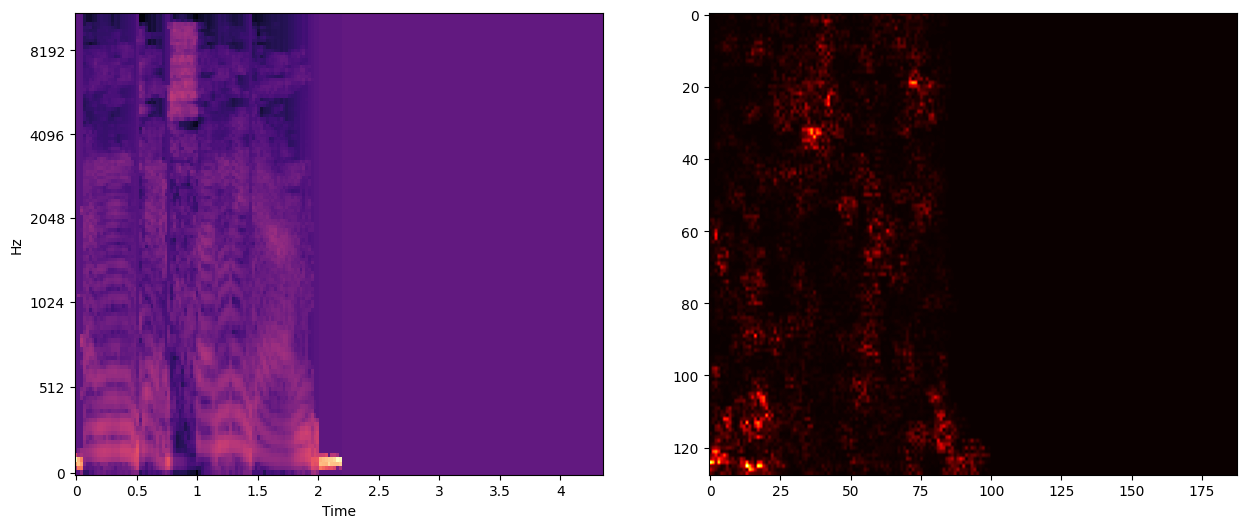

fake


In [16]:

# Define function that analizes single audio file
def analizeSingleFile(model, scaler, filepath, filename, plot=False):
    # Get audio
    full_file_path = os.path.join(filepath, filename + ".flac")
    audio, _ = librosa.load(full_file_path, duration=NUM_OF_SECONDS, sr=SAMPLING_RATE)
    signal = np.zeros((int(NUM_OF_SECONDS * SAMPLING_RATE,)))
    signal[:len(audio)] = audio

    # Get spectrogram
    spectrogram = getMelSpectrogram(signal, SAMPLING_RATE)

    # Scale spectrogram
    spectrogram = scaler.fit_transform(spectrogram)

    if plot:    
        fig,ax = plt.subplots(1,2, figsize=(15,6))
        librosa.display.specshow(spectrogram, ax = ax[0], y_axis='mel', x_axis='time', cmap='magma')
        print('Spectrogram shape: ', spectrogram.shape)

    # Pack spectrogram
    spectrogram = np.expand_dims(spectrogram, axis=(0, 1, 2))

    # Get tensor
    X = torch.tensor(spectrogram, device=device).float()
    X.requires_grad = True


    # Load spectrogram to neural network
    output_logits, output_softmax = model(X)
    predictions = torch.argmax(output_softmax, dim=1)

    loss = output_logits[:, 1]  # Assuming binary classification with output shape (batch_size, 2)
    
    model.zero_grad()
    loss.backward()

    saliency_scores, _ = torch.max(torch.abs(X.grad), dim=1)
    print(saliency_scores.shape)

    if plot:
        img = np.flipud(saliency_scores.squeeze())
        ax[1].imshow(img, cmap='hot', aspect='auto')
        # ax[1].set_colorbar()
        plt.show()

    pred = predictions
    pred = "real" if predictions == 1 else "fake"
    return pred
    

filepath = DATA_PATH
filename = "DF_E_2000028"
print(analizeSingleFile(model, scaler, filepath, filename, True))
